In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import time
import os

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torchvision
from torchvision import datasets
from torchvision import transforms
from torch.autograd import Variable
import torch.nn as nn
from tqdm import tqdm
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.metrics import classification_report

from datasets.syn_signs_loader import syn_signs
from models.gtsrb_cnn import GTSRB_CNN
from models.gtsrb_cnn_regular import GTSRB_CNN_regular

In [2]:
transform = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Resize((48, 48))
            ])

target_trainset = datasets.GTSRB(root = "./data", split = "train", download = True, transform = transform)
target_testset = datasets.GTSRB(root = "./data", split = "test", download = True, transform = transform)

In [3]:
# obtain training indices that will be used for validation
val_size = 0.2
num_train = len(target_trainset)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(val_size * num_train))
split = 1280
train_index, val_index = indices[split:], indices[:split] # define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_index)
val_sampler = SubsetRandomSampler(val_index)

batch_size = 64
target_trainloader = torch.utils.data.DataLoader(target_trainset, batch_size = batch_size
                                                    , num_workers = 2, sampler = train_sampler)
target_valloader = torch.utils.data.DataLoader(target_trainset, batch_size = batch_size
                                                    , num_workers = 2, sampler = val_sampler)
target_testloader = torch.utils.data.DataLoader(target_testset, batch_size = batch_size
                                                    , shuffle = True, num_workers = 2)

print("Target Train set size = %d, Val set size = %d, Test set size = %d" % (len(target_trainloader), 
                                                                      len(target_valloader), len(target_testloader)))

Target Train set size = 397, Val set size = 20, Test set size = 198


In [4]:
source_trainset = syn_signs(root = "./data/syn_signs/Images", transform = transform)

In [5]:
# obtain training indices that will be used for validation
val_size = 0.2
num_train = len(source_trainset)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(val_size * num_train))
split = num_train - 100000
train_index, val_index = indices[split:], indices[:split] # define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_index)
val_sampler = SubsetRandomSampler(val_index)

batch_size = 64
source_trainloader = torch.utils.data.DataLoader(source_trainset, batch_size = batch_size
                                                    , num_workers = 2, sampler = train_sampler)
source_valloader = torch.utils.data.DataLoader(source_trainset, batch_size = batch_size
                                                    , num_workers = 2, sampler = val_sampler)

print("Source Train set size = %d, Val set size = %d" % (len(source_trainloader), len(source_valloader)))

Source Train set size = 1563, Val set size = 353


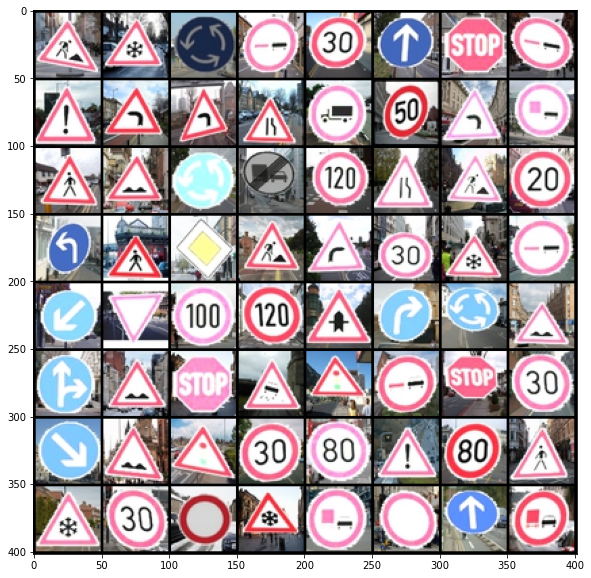

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<class 'torch.Tensor'>
torch.Size([64, 3, 48, 48])
torch.Size([64])
tensor([13, 28,  2, 11, 35, 42,  8, 10, 18,  1, 10, 11, 17,  7, 13, 25,  2,  5,
        11, 22, 25,  5, 14,  3, 12,  4, 38, 22,  2, 13, 12,  8, 11, 23, 28,  1,
        20, 31, 34, 18,  3, 16, 10,  1, 31,  6,  3, 16,  1,  1,  4,  4, 13,  6,
        18, 11, 38,  7,  2, 26, 20,  5, 30, 11])


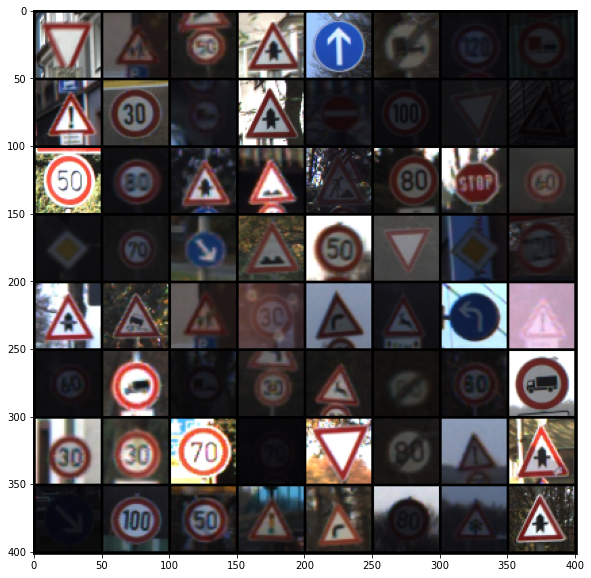

In [6]:
# let's have a look at the dataset
def imshow(img):
    img = img #/ 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(10,10))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random source training images
dataiter = iter(source_trainloader)
images, labels = dataiter.__next__()

# show images
imshow(torchvision.utils.make_grid(images))

# get some random target training images
dataiter = iter(target_trainloader)
images, labels = dataiter.__next__()
print(type(labels))
print(images.shape)
print(labels.shape)
print(labels)

# show images
imshow(torchvision.utils.make_grid(images))

In [7]:
def train(train_loaders, val_loaders, test_loader, model, optimizer, criteria, epochs = 25, model_save_path = "models/best_model.pt", scheduler = None):
    train_losses = []
    val_losses = []
    min_val_loss = np.Inf
    
    batch_size = 64
    lamda = 10
    lr0 = 0.01
    beta = 0.75

    model_save_dir = os.path.dirname(model_save_path)
    if not os.path.exists(model_save_dir):
        os.makedirs(model_save_dir)
    
    start_time = time.time()
    for epoch in range(epochs):
        model.train()
        len_dataloader = min(len(train_loaders[0]), len(train_loaders[1]))
        pbar = tqdm(total = len_dataloader, position = 0, leave = True)
        train_loss = 0
        val_loss = 0

        source_iter = iter(train_loaders[0])
        target_iter = iter(train_loaders[1])
#         for batch_idx, (data, target) in enumerate(train_loaders[0]):
        for batch_idx in range(len_dataloader):
            source_data, source_labels = source_iter.__next__()
            target_data, target_labels = target_iter.__next__()
            
            p = float(batch_idx + epoch * len_dataloader) / (epochs * len_dataloader)
            alpha = (2. / (1. + np.exp(-lamda * p))) - 1
            for g in optimizer.param_groups:
                g["lr"] = lr0 / np.power((1 + lamda * p), beta)
            
            if torch.cuda.is_available():
                print("Using CUDA")
                source_data, source_labels = source_data.cuda(), source_labels.cuda()
                target_data, target_labels = target_data.cuda(), target_labels.cuda()

            source_domain_labels = torch.zeros(source_data.shape[0])
            target_domain_labels = torch.ones(target_data.shape[0])

            optimizer.zero_grad()
            source_classes, source_domains = model(source_data, alpha)
            label_loss = criteria[0](source_classes, source_labels)
            source_domain_loss = criteria[1](source_domains[:, 0], source_domain_labels)
            
            target_classes, target_domains = model(target_data, alpha)
            target_domain_loss = criteria[1](target_domains[:, 0], target_domain_labels)
            
            loss = label_loss + source_domain_loss + target_domain_loss
            loss.backward()
            optimizer.step()

            train_loss += loss.cpu().data.item() 
            pbar.update(1)
            pbar.desc= f'Train Loss: {loss.item()}'
            
        train_loss /= len_dataloader
        train_losses.append(train_loss)
        
        if scheduler is not None:
            scheduler.step()     
            
#         if train_loss < min_val_loss:
#             min_val_loss = train_loss
#             torch.save(model.state_dict(), model_save_path)

        model.eval()
        with torch.no_grad():
            len_val_dataloader = min(len(val_loaders[0]), len(val_loaders[1]))
            source_val_iter = iter(val_loaders[0])
            target_val_iter = iter(val_loaders[1])
            
            for batch_ix in range(len_val_dataloader):
                source_val_data, source_val_labels = source_val_iter.__next__()
                target_val_data, target_val_labels = target_val_iter.__next__()
                
                source_pred_labels, source_pred_domains = model(source_val_data, alpha)
                source_label_loss = criteria[0](source_pred_labels, source_val_labels)          
                target_pred_labels, target_pred_domains = model(target_val_data, alpha)
                target_label_loss = criteria[0](target_pred_labels, target_val_labels)
                
                loss = source_label_loss + target_label_loss
                val_loss += loss.cpu().data.item() * (source_val_data.shape[0] + target_val_data.shape[0])
                
            val_loss /= len_val_dataloader
            val_losses.append(val_loss)

        if val_loss < min_val_loss:
            min_val_loss = val_loss
            torch.save(model.state_dict(), model_save_path)
            
        print("Epoch %d: Train Loss = %f, Val Loss = %f" % (epoch, train_loss, val_loss))
        pbar.refresh()
        pbar.close()

    end_time = time.time()
    train_time = end_time - start_time
    
    plot_loss(train_losses, "Train Loss vs Epochs")
    plot_loss(val_losses, "Validation Loss vs Epochs")
    
#     start_time = time.time()
#     model.load_state_dict(torch.load(model_save_path))
#     get_model_size(model)
# #     train_report = evaluate(model, train_loader, criterion)
# #     test_report = evaluate(model, test_loader, criterion)
# #     end_time = time.time()
# #     eval_time = end_time - start_time
#     print("Training time = %f seconds" % (train_time))
# #     print("Evaluation time (on both, train and test sets) = %f seconds" % (eval_time))
            
# #     return train_report, test_report
    return None, None

In [ ]:
lr = 0.01
model = GTSRB_CNN()
# optimizer = torch.optim.Adam(model.parameters(), lr = lr)    
optimizer = torch.optim.SGD(model.parameters(), lr = lr, momentum = 0.9)
criteria = [nn.NLLLoss(), nn.BCELoss()]
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma = 0.5)
scheduler = None

train_report, test_report = train([source_trainloader, target_trainloader], [source_valloader, target_valloader], 
                                  target_testloader, model, optimizer, criteria, 100, 
                                  "checkpoints/gtsrb/gtsrb_batchnorm_sgd_mom_0_9_lr_0_01_anneal.pt", scheduler)

Train Loss: 1.3483983278274536:   9%|████▌                                               | 35/397 [00:21<03:45,  1.61it/s]

In [8]:
model = GTSRB_CNN()
model_save_path = "checkpoints/gtsrb/gtsrb_batchnorm_sgd_mom_0_9_lr_0_01_anneal.pt"
model.load_state_dict(torch.load(model_save_path))
preds_labels = []
preds_domains = []
gt_labels = []

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(target_valloader):
        pred_labels, pred_domains = model(data, 1.)
        pred_labels = np.argmax(np.exp(np.array(pred_labels)), axis = 1)
        pred_domains = np.round(np.array(pred_domains))
        
        preds_labels.append(pred_labels)
        preds_domains.append(pred_domains)
        gt_labels.append(np.array(target))
        
preds_labels = np.array(preds_labels).reshape(-1)
preds_domains = np.array(preds_domains).reshape(-1)
gt_labels = np.array(gt_labels).reshape(-1)
gt_domains = np.ones(gt_labels.shape)

print("Class Label Report")
print(classification_report(preds_labels, gt_labels))

print("Domain Label Report")
print(classification_report(preds_domains, gt_domains))

Class Label Report
              precision    recall  f1-score   support

           0       0.60      0.60      0.60         5
           1       0.47      1.00      0.64        39
           2       0.29      0.73      0.41        26
           3       0.25      0.81      0.39        16
           4       0.29      1.00      0.44        22
           5       0.10      0.83      0.18         6
           6       0.24      1.00      0.38         5
           7       0.19      0.36      0.25        22
           8       0.13      0.58      0.21        12
           9       0.41      0.54      0.47        26
          10       0.46      0.61      0.53        51
          11       0.79      0.92      0.85        37
          12       0.77      0.82      0.79        61
          13       0.61      0.88      0.72        49
          14       1.00      0.47      0.64        49
          15       0.62      0.31      0.41        59
          16       0.72      0.52      0.60        25
        

In [ ]:
def train(train_loader, val_loader, test_loader, model, optimizer, criterion, epochs = 25, model_save_path = "models/best_model.pt", scheduler = None):
    train_losses = []
    val_losses = []
    min_val_loss = np.Inf

    model_save_dir = os.path.dirname(model_save_path)
    if not os.path.exists(model_save_dir):
        os.makedirs(model_save_dir)
    
    start_time = time.time()
    for epoch in range(epochs):
        model.train()
        pbar = tqdm(total = len(train_loader), position = 0, leave = True)
        train_loss = 0
        val_loss = 0

        for batch_idx, (data, target) in enumerate(train_loader):
            if torch.cuda.is_available():
                print("Using CUDA")
                data, target = data.cuda(), target.cuda()

            optimizer.zero_grad()
            out = model(data)
            loss = criterion(out, target)
            loss.backward()
            optimizer.step()

            train_loss += loss.cpu().data.item() * data.size(0)
            pbar.update(1)
            pbar.desc= f'Train Loss: {loss.item()}'

        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        
        if scheduler is not None:
            scheduler.step()
            
        model.eval()
        with torch.no_grad():
            for batch_idx, (data, target) in enumerate(val_loader):
                out = model(data)
                loss = criterion(out, target)
                val_loss += loss.cpu().data.item() * data.size(0)
                
            val_loss /= len(val_loader)
            val_losses.append(val_loss)

        if val_loss < min_val_loss:
            min_val_loss = val_loss
            torch.save(model.state_dict(), model_save_path)
            
        print("Epoch %d: Train Loss = %f, Val Loss = %f" % (epoch, train_loss, val_loss))
        pbar.refresh()
        pbar.close()

    end_time = time.time()
    train_time = end_time - start_time
    
    plot_loss(train_losses, "Train Loss vs Epochs")
    plot_loss(val_losses, "Validation Loss vs Epochs")
    
#     start_time = time.time()
#     model.load_state_dict(torch.load(model_save_path))
#     get_model_size(model)
# #     train_report = evaluate(model, train_loader, criterion)
# #     test_report = evaluate(model, test_loader, criterion)
# #     end_time = time.time()
# #     eval_time = end_time - start_time
#     print("Training time = %f seconds" % (train_time))
# #     print("Evaluation time (on both, train and test sets) = %f seconds" % (eval_time))
            
# #     return train_report, test_report
    return None, None

In [ ]:
lr = 0.01
source_only_model = GTSRB_CNN_regular()
# optimizer = torch.optim.Adam(model.parameters(), lr = lr)    
optimizer = torch.optim.SGD(model.parameters(), lr = lr, momentum = 0.9)
criterion = nn.NLLLoss()
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma = 0.5)
scheduler = None

train_report, test_report = train(source_trainloader, source_valloader, 
                                  target_testloader, source_only_model, optimizer, criterion, 100, 
                                  "checkpoints/gtsrb/gtsrb_batchnorm_source_only.pt", scheduler)

In [ ]:
lr = 0.01
target_only_model = GTSRB_CNN_regular()
# optimizer = torch.optim.Adam(model.parameters(), lr = lr)    
optimizer = torch.optim.SGD(model.parameters(), lr = lr, momentum = 0.9)
criterion = nn.NLLLoss()
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma = 0.5)
scheduler = None

train_report, test_report = train(target_trainloader, target_valloader, 
                                  target_testloader, target_only_model, optimizer, criterion, 100, 
                                  "checkpoints/gtsrb/gtsrb_batchnorm_target_only.pt", scheduler)